In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

### In this kernel we try to get a basic understanding of the problem and explore a few simple solutions to see a how they differ. 

In case you haven't already figured it out, this is a version of the ["Traveling Salesman Problem"](https://en.wikipedia.org/wiki/Travelling_salesman_problem). May be the winning solution is going to be one of the very advanced approaches to that problem. But let us not get scared by an NP-Complete problem. We will start with some simple dumb approaches first and see where they lead us. 


Let us first load the file and look at the data. 

In [2]:
df_cities = pd.read_csv('citiesRudolph.csv')
df_cities.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


### Taking a cue from the other kernels, let us first do a scatter plot of the locations of all the cities. 
* There is a surpise waiting in the locations of the cities :)

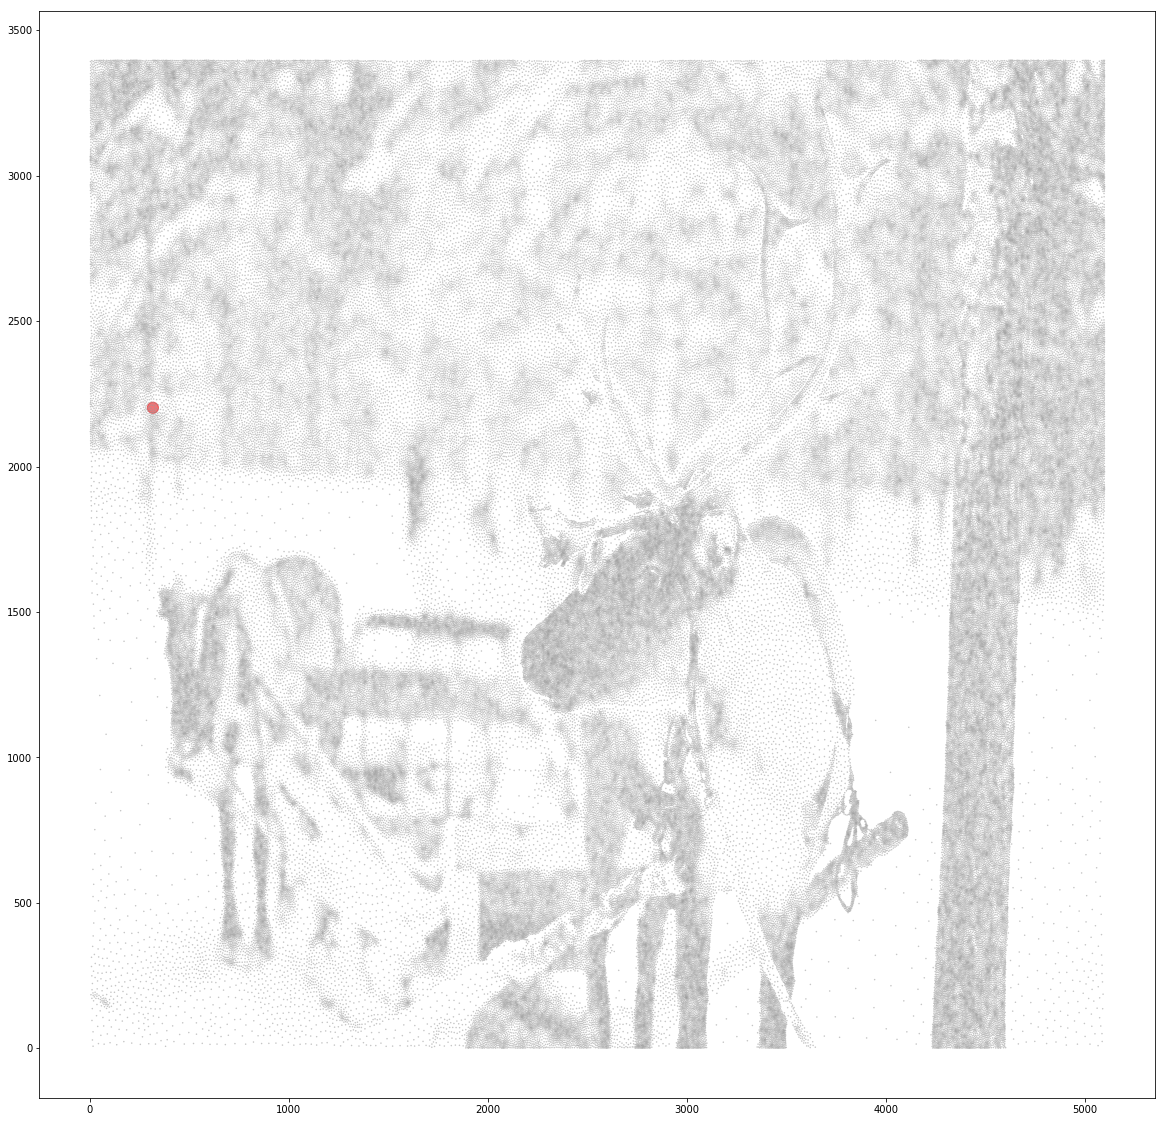

In [3]:
fig = plt.figure(figsize=(20,20))
#cmap, norm = from_levels_and_colors([0.0, 0.5, 1.5], ['red', 'black'])
plt.scatter(df_cities['X'],df_cities['Y'],marker = '.',c=(df_cities.CityId != 0).astype(int), cmap='Set1', alpha = 0.6, s = 500*(df_cities.CityId == 0).astype(int)+1)
plt.show()

**So it looks like the cities are arranged in a reindeer pattern**. 
* The red dot indicates the North Pole (CityId = 0). 
* All we have to a do a is a find a path that goes from the red dot, touches all the other dots, and comes back to the red-dot, with minimum total distance travelled !

## Dumbest Path: Go in the order of CityIDs: 0, 1, 2.. etc. and come back to zero when you reach the end. 

Per the problem: **"submission is scored on the Euclidean distance of your submitted path, subject to the constraint that every 10th step is 10% more lengthy unless coming from a prime CityId."**

To see how good this path is, we need a couple of functions: 
1. A function to tell if a number is a prime
2. Another funtion to compute the total distance given a series of numbers

In [4]:
# To improve the performance, instead of checking whether each member is a prime, 
# we first a generate a list where each element tells whether the number indicated 
# by the position is a prime or not. 

# using sieve of eratosthenes
def sieve_of_eratosthenes(n):
    primes = [True for i in range(n+1)] # Start assuming all numbers are primes
    primes[0] = False # 0 is not a prime
    primes[1] = False # 1 is not a prime
    for i in range(2,int(np.sqrt(n)) + 1):
        if primes[i]:
            k = 2
            while i*k <= n:
                primes[i*k] = False
                k += 1
    return(primes)
prime_cities = sieve_of_eratosthenes(max(df_cities.CityId))

In [5]:
def total_distance(dfcity,path):
    prev_city = path[0]
    total_distance = 0
    step_num = 1
    for city_num in path[1:]:
        next_city = city_num
        total_distance = total_distance + \
            np.sqrt(pow((dfcity.X[city_num] - dfcity.X[prev_city]),2) + pow((dfcity.Y[city_num] - dfcity.Y[prev_city]),2)) * \
            (1+ 0.1*((step_num % 10 == 0)*int(not(prime_cities[prev_city]))))
        prev_city = next_city
        step_num = step_num + 1
    return total_distance

dumbest_path = list(df_cities.CityId[:].append(pd.Series([0])))
print('Total distance with the dumbest path is '+ "{:,}".format(total_distance(df_cities,dumbest_path)))

Total distance with the dumbest path is 446,884,407.5212135


### Let us take a look at the first 100 steps of the dumbest path

In [6]:
df_path = pd.merge_ordered(pd.DataFrame({'CityId':dumbest_path}),df_cities,on=['CityId'])
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(df_path.iloc[0:100,]['X'], df_path.iloc[0:100,]['Y'],marker = 'o')
for i, txt in enumerate(df_path.iloc[0:100,]['CityId']):
    ax.annotate(txt, (df_path.iloc[0:100,]['X'][i], df_path.iloc[0:100,]['Y'][i]),size = 15)

### As we can see, the dumbest path seems pretty bad. We are sending Santa all over the map, without any consideration for him whatsoever :)

## Slightly better path: sort the cities in X,Y coordinate_order

In [7]:
sorted_cities = list(df_cities.iloc[1:,].sort_values(['X','Y'])['CityId'])
sorted_cities = [0] + sorted_cities + [0]
print('Total distance with the sorted city path is '+ "{:,}".format(total_distance(df_cities,sorted_cities)))

Total distance with the sorted city path is 196,478,811.25956938


### We already reduced our total distance by more than half using a simple sorting !!  Let us look at how it looks in a map (zoomed in) . 

In [8]:
df_path = pd.DataFrame({'CityId':sorted_cities}).merge(df_cities,how = 'left')
fig, ax = plt.subplots(figsize=(20,20))
ax.set_xlim(0,10)
ax.plot(df_path.iloc[0:100,]['X'], df_path.iloc[0:100,]['Y'],marker = 'o')
for i, txt in enumerate(df_path.iloc[0:100,]['CityId']):
    ax.annotate(txt, (df_path.iloc[0:100,]['X'][i], df_path.iloc[0:100,]['Y'][i]),size = 15)

### From the plot above, we can also see that now Santa is going up and down around the same X value (note X axis only ranges from 0-10), before moving to the next X. This is slightly more efficient path. 

**<span style="color:red">Question for more experienced matplotlib users:</span>  Can anyone tell me why I am seeing a big white space above this figure ? **


## Iteration 3 : Sorted cities within a grid of squares

One of the problems we can see with the previous Path is that though Santa is moving in a systematic left-to-right fashion, he is moving between the extremes of the Y-axis while doing that. 

If we divide the the whloe network into a grid of X's and Y's, then Santa can cover each square in the grid, before moving on to the next square. It should be more efficient as shown below. 

In [9]:
df_cities['Ycuts'] = pd.cut(df_cities.Y,300)
df_cities['Xcuts'] = pd.cut(df_cities.X,300)
grid_sorted_cities = list(df_cities.iloc[1:].sort_values(['Xcuts','Ycuts','X','Y'])['CityId'])
grid_sorted_cities =  [0] + grid_sorted_cities + [0]
print('Total distance with the sorted cities with a grid path is '+ "{:,}".format(total_distance(df_cities,grid_sorted_cities)))

Total distance with the sorted cities with a grid path is 3,226,331.4903367283


In [10]:
df_path = pd.DataFrame({'CityId':grid_sorted_cities}).merge(df_cities,how = 'left')
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(df_path.iloc[0:1000,]['X'], df_path.iloc[0:1000,]['Y'],marker = 'o')

### Great improvement with sliced, sorted cities in terms of score.  

### We can now see that Santa is going to a point, trying to cover many of the cities around that point, before moving up. This feels like a better way to cover all the cities and gives better results as expected. 


## Iteration 4: Grid of Squares + Zig Zag Scanning

 One of the above problems we can see in the above path is that once Santa reaches the city with the highest Y, he comes back all the way to city with lowest-Y and starts moving up, as opposed, following a zig-zag pattern which should be more efficient. 
 * Let us see if we an implement a zig-zag path and get some more improvement. 

In [11]:
zigzag_sorted_cities1 = list(df_cities.iloc[1:].sort_values(['Xcuts','Ycuts','X','Y'])['CityId'])
zigzag_sorted_cities2 = list(df_cities.iloc[1:].sort_values(['Xcuts','Ycuts','X','Y'], ascending = [True,False,True,True])['CityId'])
chooser_pattern = list(df_cities.iloc[1:].sort_values(['Xcuts']).groupby(['Xcuts']).ngroup()%2)

zigzag_cities = [zigzag_sorted_cities1[i] if chooser_pattern[i] == 0 else zigzag_sorted_cities2[i] for i in range(len(chooser_pattern))]
zigzag_cities =  [0] + zigzag_cities + [0]
print('Total distance with the Zig-Zag with grid city path is '+ "{:,}".format(total_distance(df_cities,zigzag_cities)))

Total distance with the Zig-Zag with grid city path is 2,233,635.0317220334


### By introducing a zig-zag path at the grid-level, we eliminated those long trips for Santa from highest Y to lowest-Y and further improved the score from 3.2 million to 2.2 million. 

Let us see how this path looks.

In [ ]:
df_path = pd.DataFrame({'CityId':zigzag_cities}).merge(df_cities,how = 'left')
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(df_path.iloc[0:1000,]['X'], df_path.iloc[0:1000,]['Y'],marker = 'o')

**We sort of arbitrarily chose the grid size of 300x300 grid size. Next let us see if the grid size makes a difference**
## Iteration #5 Optimizing for grid-size:

In [ ]:
for i in range(100,600,100):
    for j in range(100,600,100):
        df_cities['Ycuts'] = pd.cut(df_cities.Y,j)
        df_cities['Xcuts'] = pd.cut(df_cities.X,i)
        zigzag_sorted_cities1 = list(df_cities.iloc[1:].sort_values(['Xcuts','Ycuts','X','Y'])['CityId'])
        zigzag_sorted_cities2 = list(df_cities.iloc[1:].sort_values(['Xcuts','Ycuts','X','Y'], ascending = [True,False,True,True])['CityId'])
        chooser_pattern = list(df_cities.iloc[1:].sort_values(['Xcuts']).groupby(['Xcuts']).ngroup()%2)

        zigzag_cities = [zigzag_sorted_cities1[i] if chooser_pattern[i] == 0 else zigzag_sorted_cities2[i] for i in range(len(chooser_pattern))]
        zigzag_cities =  [0] + zigzag_cities + [0]
        print('Total distance with the Zig-Zag with grid city path with grid size (' + str(i) + ',' + str(j) + ") is {:,}".format(total_distance(df_cities,zigzag_cities)))

Total distance with the Zig-Zag with grid city path with grid size (100,100) is 3,243,001.24552974
Total distance with the Zig-Zag with grid city path with grid size (100,200) is 2,483,012.2590593975
Total distance with the Zig-Zag with grid city path with grid size (100,300) is 2,458,138.678978236
Total distance with the Zig-Zag with grid city path with grid size (100,400) is 2,600,638.502037033
Total distance with the Zig-Zag with grid city path with grid size (100,500) is 2,779,870.5123764514
Total distance with the Zig-Zag with grid city path with grid size (200,100) is 3,354,740.6090092813


In [ ]:
df_path = pd.DataFrame({'CityId':zigzag_cities}).merge(df_cities,how = 'left')
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(df_path['X'], df_path['Y'])

**It looks like (300,500) is better grid-size than (300,300), but not my much.  Well, all experiments don't work :)**\

Let us take a look on how the final graph looks with the above algorithm. 

## Iteration 6: Nearest Neighbor / Greedy Algorithm: 

**[Wikipedia link](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Computing_a_solution) says Nearest Neighbor approach is one of the easier heuristic approaches to solve the traveling salesman problem.  Let us see how much improvement we can get with it. **

For the nearest neighbor algorithm, we will use the function from [XYZT's Kernel in the same competition:](https://www.kaggle.com/thexyzt/xyzt-s-visualizations-and-various-tsp-solvers)

In [ ]:
# Function from XYZT's Kernel on the same topic. 
def nearest_neighbour():
    cities = pd.read_csv("../input/cities.csv")
    ids = cities.CityId.values[1:]
    xy = np.array([cities.X.values, cities.Y.values]).T[1:]
    path = [0,]
    while len(ids) > 0:
        last_x, last_y = cities.X[path[-1]], cities.Y[path[-1]]
        dist = ((xy - np.array([last_x, last_y]))**2).sum(-1)
        nearest_index = dist.argmin()
        path.append(ids[nearest_index])
        ids = np.delete(ids, nearest_index, axis=0)
        xy = np.delete(xy, nearest_index, axis=0)
    path.append(0)
    return path

nnpath = nearest_neighbour()
print('Total distance with the Nearest Neighbor path '+  "is {:,}".format(total_distance(df_cities,nnpath)))

### Nearest neighbor algorithm offered a significant improvement from a cost of about 2.2 million to 1.8 million. 

Let us see how the path looks with the neaerst neighbor alrgorithm. 

In [ ]:
df_path = pd.DataFrame({'CityId':nnpath}).merge(df_cities,how = 'left')
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(df_path['X'], df_path['Y'])

## Let us submit the best path we have so far to the competition ...

In [ ]:
pd.DataFrame({'Path':nnpath}).to_csv('nearest_neighbor_cities.csv',index  = False)

<font color='red'>** More to come .. **</font>